## Wine Quality Predictor

* Paper: https://www.semanticscholar.org/paper/Modeling-wine-preferences-by-data-mining-from-Cortez-Cerdeira/bf15a0ccc14ac1deb5cea570c870389c16be019c
The purpose of this project is to try to predict the wine quality with two datasets of Portuguese red and white wine variants, depending on different variables.

The columns in the datasets are as follows:

1. fixed acidity: most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
2. volatile acidity: the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
3. citric acid: found in small quantities, citric acid can add 'freshness' and flavor to wines
4. residual sugar: the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet
5. chlorides: the amount of salt in the wine
6. free sulfur dioxide: the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine
7. total sulfur dioxide: amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine
8. density: the density of wine is close to that of water depending on the percent alcohol and sugar content
9. pH: describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale
10. sulphates: a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant
11. alcohol: the percent alcohol content of the wine

There are two datasets, one for red wine and one for white wine. The goal is to model wine quality.

In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, mean_absolute_error, r2_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler

In [40]:
data_1 = pd.read_csv("winequality-red.csv")
data_2 = pd.read_csv('winequality-white.csv')

data_1["type"] = "red"
data_2["type"] = "white"
data_2.head()

data = pd.concat([data_1, data_2], axis=0)

data.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
4363,7.1,0.31,0.25,11.20,0.048,32.0,136.0,0.99663,3.14,0.40,9.5,5,white
2963,7.5,0.38,0.29,4.90,0.021,38.0,113.0,0.99026,3.08,0.48,13.0,7,white
1684,7.3,0.26,0.33,17.85,0.049,41.5,195.0,1.00000,3.06,0.44,9.1,7,white
4462,7.1,0.42,0.20,2.80,0.038,28.0,109.0,0.98968,3.23,0.47,13.4,6,white
1242,8.1,0.43,0.42,6.60,0.033,36.0,141.0,0.99180,2.98,0.39,13.3,7,white


## Data Cleaning

In [3]:
encoder = LabelEncoder()

data["type"] = encoder.fit_transform(data["type"])
    
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,1
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1


In [4]:
data["quality"].nunique()

7

<Axes: ylabel='Frequency'>

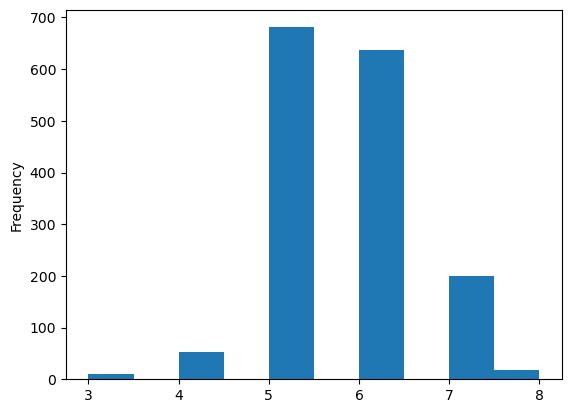

In [5]:
data_1['quality'].plot(kind='hist') ##red_wine

<Axes: ylabel='Frequency'>

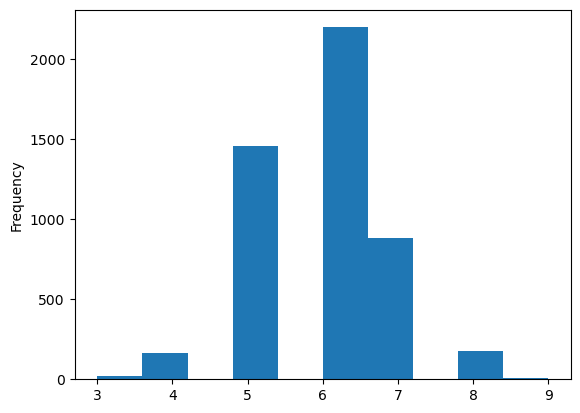

In [6]:
data_2['quality'].plot(kind='hist') ##white_wine

Let's convert the target variable into a binary one. Since we have a normal distribution in the data, let's use the last quartile of the data, as the 25% highest value should be the best wines. So the threshold would be 7, meaning any wine scored equal or above 7 will have 1 as a code, and below a 0.

In [7]:
## converting the target variable to binary

data["target"] = pd.cut(data['quality'], bins=[0,6,10], labels=False)

data.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,target
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1,0
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,1,0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1,0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1,1
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,1,0


In [8]:
data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
type                      int32
target                    int64
dtype: object

In [9]:
data["quality"] = data["quality"].astype(float)
data["type"] = data["type"].astype(float)
data["target"] = data["target"].astype(float)

data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                 float64
type                    float64
target                  float64
dtype: object

## New Features Creation

In [10]:
data["density_alcohol"] = data["density"] / data ["alcohol"]

data["pH_categorical"] = pd.cut(data['pH'], bins=5, labels=False)

data["alcohol_sugar"] = data["alcohol"] / data ["residual sugar"]

data["alcohol_categorical"] = pd.cut(data['alcohol'], bins=5, labels=False)

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,target,density_alcohol,pH_categorical,alcohol_sugar,alcohol_categorical
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0,0.0,0.0,0.106149,3,4.947368,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0,0.0,0.0,0.101714,1,3.769231,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0,0.0,0.0,0.101735,2,4.260870,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0,0.0,0.0,0.101837,1,5.157895,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0,0.0,0.0,0.106149,3,4.947368,1


## Data Splitting

In [11]:
data.drop("quality", axis=1, inplace=True)

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,target,density_alcohol,pH_categorical,alcohol_sugar,alcohol_categorical
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0,0.0,0.106149,3,4.947368,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0.0,0.0,0.101714,1,3.769231,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0.0,0.0,0.101735,2,4.260870,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0.0,0.0,0.101837,1,5.157895,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0,0.0,0.106149,3,4.947368,1


In [12]:
x = data.drop('target', axis=1)
y = data['target']

In [13]:
x.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,density_alcohol,pH_categorical,alcohol_sugar,alcohol_categorical
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0,0.106149,3,4.947368,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0.0,0.101714,1,3.769231,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0.0,0.101735,2,4.260870,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0.0,0.101837,1,5.157895,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0,0.106149,3,4.947368,1


In [14]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: target, dtype: float64

In [15]:
#Checking for unblanaced data
data['target'].value_counts()

target
0.0    5220
1.0    1277
Name: count, dtype: int64

In [16]:
X_train, X_test, y_train, y_test = train_test_split( ##it gives back 4 arrays
    x, y,               # arrays or matrices I want to split
    test_size=0.3,      # the proportion to data for testing (if its an integer, how many rows do you want from the dataset)
    random_state=123,   # can be any number. make the split reproducibile
    shuffle=True,       # if we want to shuffle data before splitting (this is good if we are not using time series)
    stratify=y       # For clasification problems. Split data stratifying the target variable (for classificatino problem when the data is not balanced)
)

# Display the sizes of the training and testing sets
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Training set size:", y_train.shape)
print("Testing set size:", y_test.shape)

Training set size: (4547, 16)
Testing set size: (1950, 16)
Training set size: (4547,)
Testing set size: (1950,)


## Data Scaling

In [18]:
## Since the data is unblanaced, I will use robust scaler for a better scaling

scaler = RobustScaler()

scaler.fit(X_train)
x_train_sc = scaler.transform(X_train)
x_test_sc = scaler.transform(X_test)

## ML Algorithm without hyperparameter tuning

In [23]:
model = RandomForestClassifier()

rf = RandomForestClassifier()

rf.fit(x_train_sc, y_train)


RandomForestClassifier()

In [33]:
y_pred = rf.predict(x_test_sc)

# F1 Score
F1_RF = f1_score(y_test, y_pred, average='binary')
print("F1 Score:", f1)

F1 Score: 0.6397608370702541


## Grid Search

In [51]:
grid_rf = {
 #  "n_estimators": [100, 200, 300],
    "max_depth": [40, 50, 30],
 #  "min_samples_split": [10, 20, 30],
    "min_samples_leaf": [3, 4, 5],
    "max_features": [5, 7 , 9], #SQUARED ROOT OF THE VARIABLES
   "criterion": ["gini", "entropy"]
                     }


gs_rf = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf,
    scoring='f1', 
    cv=5,
)

gs_rf.fit(x_train_sc, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [40, 50, 30], 'max_features': [5, 6, 7],
                         'min_samples_leaf': [3, 4, 5]},
             scoring='f1')

## Algorithm Trainning with best parameters

In [ ]:
### TRY 1

In [41]:
best_params_rf = gs_rf.best_params_
best_params_rf

{'max_depth': 50,
 'max_features': 9,
 'min_samples_leaf': 3,
 'min_samples_split': 10}

In [42]:
best_rf = RandomForestClassifier(**best_params_rf)
best_rf.fit(x_train_sc, y_train)
best_pred_rf = best_rf.predict(x_test_sc)

In [43]:
best_f1_rf = f1_score(best_pred_rf, y_test)

print(f"Initial Model: {F1_RF}",f"Best Model: {best_f1_rf}")
print(f"Improvement:{best_f1_rf - F1_RF}")

Initial Model: 0.6397608370702541 Best Model: 0.6003016591251886
Improvement:-0.03945917794506548


In [ ]:
## TRY 2 CHANGING HYPERPARAMETERS

In [47]:
best_params_rf = gs_rf.best_params_
best_params_rf

{'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 7,
 'min_samples_leaf': 3}

In [49]:
best_rf = RandomForestClassifier(**best_params_rf)
best_rf.fit(x_train_sc, y_train)
best_pred_rf = best_rf.predict(x_test_sc)

In [50]:
best_f1_rf = f1_score(best_pred_rf, y_test)

print(f"Initial Model: {F1_RF}",f"Best Model: {best_f1_rf}")
print(f"Improvement:{best_f1_rf - F1_RF}")

Initial Model: 0.6397608370702541 Best Model: 0.6261127596439168
Improvement:-0.013648077426337335


In [ ]:
## TRY 3 CHANGING HYPERPARAMETERS

In [52]:
best_params_rf = gs_rf.best_params_
best_params_rf

{'criterion': 'entropy',
 'max_depth': 40,
 'max_features': 7,
 'min_samples_leaf': 3}

In [53]:
best_rf = RandomForestClassifier(**best_params_rf)
best_rf.fit(x_train_sc, y_train)
best_pred_rf = best_rf.predict(x_test_sc)

In [56]:
best_f1_rf = f1_score(best_pred_rf, y_test)

print(f"Initial Model: {F1_RF}",f"Best Model: {best_f1_rf}")
print(f"Improvement:{(1 - (F1_RF / best_f1_rf)) * 100}")

Initial Model: 0.6397608370702541 Best Model: 0.6201780415430267
Improvement:-3.1576086567826067


In [ ]:
## TRY 4 LETS TRY TO DELETE THE CREATED FEATURES IN FEATURE ENGINEERING

In [63]:
pd.DataFrame(x_train_sc)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,6.615385,1.972222,1.200000,0.209677,1.714286,-0.791667,-1.242718,1.805252,-1.380952,1.352941,0.444444,-1.0,-0.357228,-1.0,-0.204861,1.0
1,0.230769,-0.055556,1.533333,1.612903,0.071429,1.375000,0.563107,0.765864,-0.714286,-0.352941,-0.666667,0.0,0.767879,0.0,-0.622262,-1.0
2,1.461538,0.222222,0.066667,-0.225806,0.000000,-0.750000,1.048544,0.109409,-0.095238,-0.294118,-0.500000,0.0,0.545616,0.0,0.575855,0.0
3,1.000000,-0.500000,2.866667,0.250000,-0.107143,0.166667,0.142395,-0.547046,0.190476,-0.529412,1.055556,0.0,-0.882515,1.0,-0.183593,2.0
4,1.000000,2.055556,-1.066667,-0.161290,1.142857,-0.500000,-0.996764,0.503282,0.476190,0.176471,-0.388889,-1.0,0.428185,1.0,0.314302,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4542,-0.230769,-0.333333,0.533333,-0.064516,4.464286,1.416667,0.504854,-0.262582,-0.476190,-0.882353,-0.500000,0.0,0.535095,0.0,0.035817,0.0
4543,0.384615,0.500000,1.266667,1.596774,-0.178571,1.166667,0.841424,0.765864,-0.571429,-0.294118,-0.722222,0.0,0.838796,0.0,-0.622758,-1.0
4544,-0.384615,-0.388889,-0.400000,2.290323,0.107143,0.625000,0.245955,1.137856,0.428571,-0.823529,-0.833333,0.0,0.996703,1.0,-0.663369,-1.0
4545,-0.076923,-0.277778,0.133333,0.306452,-0.250000,-0.541667,0.155340,-0.284464,0.238095,0.764706,0.222222,0.0,-0.212611,1.0,-0.293987,0.0


In [66]:
x_train_sc_N = pd.DataFrame(x_train_sc).drop([12,13,14,15],axis=1)
x_test_sc_N = pd.DataFrame(x_test_sc).drop([12,13,14,15],axis=1)
best_rf = RandomForestClassifier(**best_params_rf)
best_rf.fit(x_train_sc_N, y_train)
best_pred_rf = best_rf.predict(x_test_sc_N)

In [67]:
best_f1_rf = f1_score(best_pred_rf, y_test)

print(f"Initial Model: {F1_RF}",f"Best Model: {best_f1_rf}")
print(f"Improvement:{(1 - (F1_RF / best_f1_rf)) * 100}%")

Initial Model: 0.6397608370702541 Best Model: 0.6206896551724138
Improvement:-3.072579305763168


In [ ]:
## TRY 5 One last time with all the hyperparameters and RandomizeGridSearch

In [69]:
grid_rf = {
   "n_estimators": [100, 200, 300],
    "max_depth": [40, 50, 30],
   "min_samples_split": [10, 20, 30],
    "min_samples_leaf": [3, 4, 5],
    "max_features": [5, 7 , 9], #SQUARED ROOT OF THE VARIABLES
   "criterion": ["gini", "entropy"]
                     }

rs_rf = RandomizedSearchCV(
    estimator=rf,                               # this is the instantiated estimator object, that is, the model we want to tune
    param_distributions=grid_rf,    # this is the predefinad search space
    scoring="f1",                  # the metric we want the tuner calculates in order to select the best combination
    cv=5,                              # the cross-validation schema we want to use (same as in the "cross_validate" or "cross_val_score")
    n_jobs=-1,                         # this is to indicate the operative system to use all processor cores and speed up the process,
    n_iter=20                          # the number of attempts we want to perform
)

rs_rf.fit(x_train_sc, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [40, 50, 30],
                                        'max_features': [5, 7, 9],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [10, 20, 30],
                                        'n_estimators': [100, 200, 300]},
                   scoring='f1')

In [70]:
best_params_rf = rs_rf.best_params_
best_params_rf

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_features': 9,
 'max_depth': 50,
 'criterion': 'entropy'}

In [71]:
best_rf = RandomForestClassifier(**best_params_rf)
best_rf.fit(x_train_sc, y_train)
best_pred_rf = best_rf.predict(x_test_sc)

In [72]:
best_f1_rf = f1_score(best_pred_rf, y_test)

print(f"Initial Model: {F1_RF}",f"Best Model: {best_f1_rf}")
print(f"Improvement:{(1 - (F1_RF / best_f1_rf)) * 100}")

Initial Model: 0.6397608370702541 Best Model: 0.6096096096096095
Improvement:-4.945989529258443


#### After trying several steps to improve the F1 score of the Random Forest Model by changing hyperparametrs and playing with created features in feature engineering, it may lead that we need to try other models (Like XGBoosting) to see if there's a better performance on the testing set with them.

In [75]:
pd.DataFrame(best_pred_rf).to_csv("C:/Users/emili/Downloads/predictions.csv")